In [100]:
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyproj import CRS, Transformer
from shapely.geometry import Polygon
from tqdm import tqdm

tqdm.pandas()

In [2]:
df = pd.read_parquet("../../data/geocoded/census_geocoder.parquet")

In [3]:
df.head()

,hud_id,project,proj_add,proj_cty,proj_st,proj_zip,state_id,latitude,longitude,place1990,...,matchtype,parsed,tigerlineid,side,statefp,countyfp,tract,block,lat,lon
0,AKA0000X003,EAGLE RIDGE TOWNHOMES,1775 NORTH THUMA,PALMER,AK,99645,AK-05-23,61.587872,-149.099777,NaN,...,None,None,None,None,None,None,None,None,NaN,NaN
1,AKA0000X018,"GATEWAY-SEWARD ASSOCIATES, LTD PTN",1810 PHOENIX ROAD,SEWARD,AK,99664,AK-99-99,60.125469,-149.446060,NaN,...,Exact,"1810 PHOENIX RD, SEWARD, AK, 99664",191035270,L,02,122,001300,2059,60.125024,-149.445991
2,AKA0000X022,"JUNEAU AFFORDABLE RENTALS, LLC",SCATTERED SITE,JUNEAU,AK,99801,AK-99-99,58.383499,-134.437698,NaN,...,None,None,None,None,None,None,None,None,NaN,NaN
3,AKA0000X024,"MILL BAY TOWNHOMES, LLC",1223 MILL BAY ROAD,KODIAK,AK,99615,AK-99-99,57.796478,-152.392319,NaN,...,Exact,"1223 MILL BAY RD, KODIAK, AK, 99615",193545416,L,02,150,000200,3003,57.796589,-152.391638
4,AKA0000X030,TURNAGAIN PLACE APTS,2708 COHO WAY,ANCHORAGE,AK,99517,AK-99-99,61.205101,-149.930298,NaN,...,None,None,None,None,None,None,None,None,NaN,NaN


In [4]:
missing_add_or_cty = df["proj_add"].isna() | df["proj_cty"].isna()
missing_orig_lat_lon = df["latitude"].isna() | df["longitude"].isna()
missing_cg_lat_lon = df["lat"].isna() | df["lon"].isna()

In [5]:
print(f"# Missing original address or city: {missing_add_or_cty.sum()}")
print(f"# Missing original lat or long: {missing_orig_lat_lon.sum()}")
print(f"# Missing cg lat or long: {missing_cg_lat_lon.sum()}")

# So a very small number of places can be reverse geocoded it seems
print(
    f"# Missing original address or city & original lat or lon: {(missing_add_or_cty & missing_orig_lat_lon).sum()}"
)

# Missing original address or city: 990
# Missing original lat or long: 2394
# Missing cg lat or long: 9343
# Missing original address or city & original lat or lon: 954


In [6]:
# Let's check the original lat/lon versus the cg lat/lon when it exists
focus_df = df[~missing_orig_lat_lon & ~missing_cg_lat_lon]

In [19]:
orig_gdf = gpd.GeoDataFrame(
    focus_df[["my_id"]],
    geometry=gpd.points_from_xy(focus_df["longitude"], focus_df["latitude"]),
    crs="epsg:4326",
)
cg_gdf = gpd.GeoDataFrame(
    focus_df[["my_id"]],
    geometry=gpd.points_from_xy(focus_df["lon"], focus_df["lat"]),
    crs="epsg:4326",
)

<AxesSubplot: >

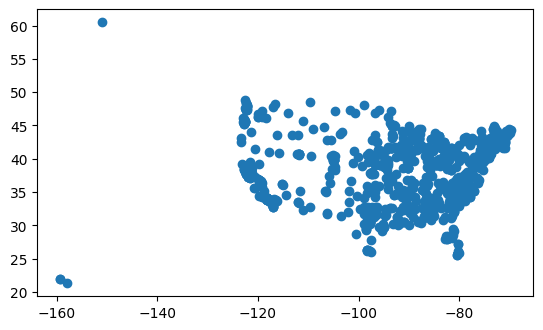

In [20]:
# Make sure the CRS is correct
orig_gdf.sample(n=1_000).plot()

<AxesSubplot: >

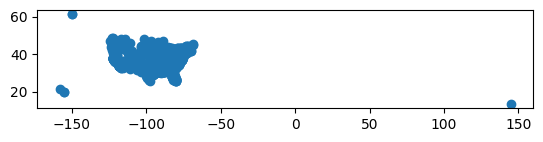

In [21]:
cg_gdf.sample(n=1_000).plot()

In [22]:
df = pd.read_csv("../../data/county-epsg.csv")

In [24]:
# This number should be around 124
epsg_df = pd.DataFrame({"epsg": df["EPSG"].unique()})

geometry = []
for i in range(len(epsg_df)):
    crs = CRS(epsg_df["epsg"].iloc[i])
    l = list(
        map(
            float,
            [x for x in repr(crs).split("\n") if x.startswith("- bounds:")][0][
                len("- bounds: (") : -1
            ].split(", "),
        )
    )
    geometry.append(Polygon([(l[0], l[1]), (l[0], l[3]), (l[2], l[3]), (l[2], l[1])]))

epsg_gdf = gpd.GeoDataFrame(
    epsg_df,
    geometry=geometry,
)

<AxesSubplot: >

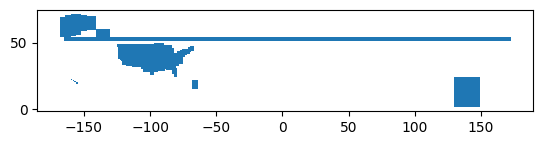

In [25]:
# Should generally look vaguely US-like
epsg_gdf.plot()

In [29]:
orig_sjoined_df = gpd.sjoin(orig_gdf, epsg_gdf, how="left")

/var/folders/_8/wxdcgmrd7b931622mzvpxn6c0000gq/T/ipykernel_74141/3620345625.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  orig_sjoined_df = gpd.sjoin(orig_gdf, epsg_gdf, how="left")


In [31]:
# So some of these have a *lot* of geometries
orig_sjoined_df["my_id"].value_counts()

9893     4
42144    4
46104    4
40652    4
11088    4
        ..
20841    1
20838    1
20837    1
20836    1
25747    1
Name: my_id, Length: 41219, dtype: int64

In [33]:
# and a very small number don't have any epsg womp womp
orig_sjoined_df["epsg"].isna().sum()

10

<AxesSubplot: >

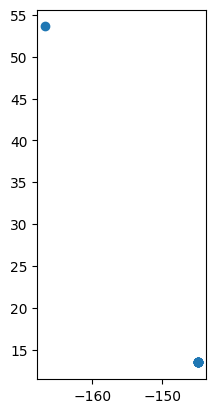

In [36]:
# These seem to be in Alaska and Puerto Rico, which isn't super shocking. We can ignore
# these for this analysis
orig_sjoined_df[orig_sjoined_df["epsg"].isna()].plot()

In [37]:
cg_sjoined_df = gpd.sjoin(cg_gdf, epsg_gdf, how="left")

/var/folders/_8/wxdcgmrd7b931622mzvpxn6c0000gq/T/ipykernel_74141/3180315460.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  cg_sjoined_df = gpd.sjoin(cg_gdf, epsg_gdf, how="left")


In [38]:
# So some of these have a *lot* of geometries
cg_sjoined_df["my_id"].value_counts()

42222    4
9912     4
10605    4
39632    4
13150    4
        ..
20852    1
20851    1
20849    1
20847    1
25747    1
Name: my_id, Length: 41219, dtype: int64

In [40]:
# and a very small number don't have any epsg womp womp
cg_sjoined_df["epsg"].isna().sum()

1

<AxesSubplot: >

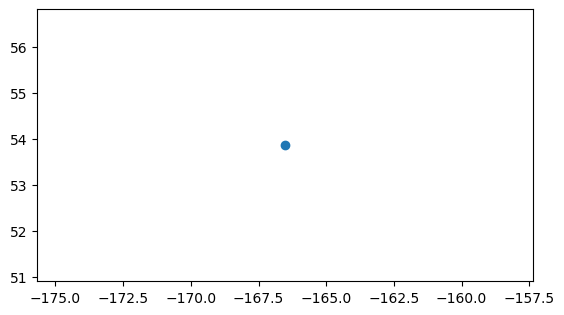

In [41]:
# This also seems to be in Alaska. So we'll again ignore this
cg_sjoined_df[cg_sjoined_df["epsg"].isna()].plot()

In [54]:
# Which to choose?
joined_epsg = orig_sjoined_df.drop(columns="index_right").merge(
    cg_sjoined_df.rename(columns={"epsg": "cg_epsg", "geometry": "cg_geometry"}).drop(
        columns=["index_right"]
    ),
    how="left",
    on="my_id",
)

In [55]:
# So all but 9 share at least one EPSG
print(
    f"How many share at least one common EPSG? {joined_epsg[joined_epsg['epsg'] == joined_epsg['cg_epsg']]['my_id'].nunique()}"
)
print(f"How many are there? {joined_epsg['my_id'].nunique()}")

How many share at least one common EPSG? 41208
How many are there? 41219


In [65]:
# Let's just take the first in order; though we should examine this
of_interest = joined_epsg[joined_epsg["epsg"] == joined_epsg["cg_epsg"]]

In [76]:
WGS_CRS = CRS(4326)

# This is going to take a long time because there's a different CRS for every pair
# Really this should be able to be a lot faster but yay python for loops :-)
geometry_crs_x = []
geometry_crs_y = []
cg_geometry_crs_x = []
cg_geometry_crs_y = []
for _, row in tqdm(of_interest.iterrows(), total=len(of_interest)):
    transformer = Transformer.from_crs(WGS_CRS, CRS(int(row["epsg"])))
    geo = transformer.transform(row["geometry"].y, row["geometry"].x)
    geometry_crs_x.append(geo[0])
    geometry_crs_y.append(geo[1])
    geo = transformer.transform(row["cg_geometry"].y, row["cg_geometry"].x)
    cg_geometry_crs_x.append(geo[0])
    cg_geometry_crs_y.append(geo[1])

100%|██████████| 60351/60351 [09:50<00:00, 102.24it/s]


In [82]:
of_interest["cg_geometry_crs_x"] = cg_geometry_crs_x
of_interest["cg_geometry_crs_y"] = cg_geometry_crs_y
of_interest["geometry_crs_x"] = geometry_crs_x
of_interest["geometry_crs_y"] = geometry_crs_y
of_interest["geometry_dist_m"] = np.sqrt(
    (of_interest["cg_geometry_crs_x"] - of_interest["geometry_crs_x"]) ** 2
    + (of_interest["cg_geometry_crs_y"] - of_interest["geometry_crs_y"]) ** 2
)

/Users/kwilso14/repo/fun/redo-lihtc/.venv/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [87]:
# So among those places that have different CRSs, the distances are off by up to 5m
(
    of_interest.groupby("my_id")["geometry_dist_m"].max()
    - of_interest.groupby("my_id")["geometry_dist_m"].min()
).max()

4.826834570634674

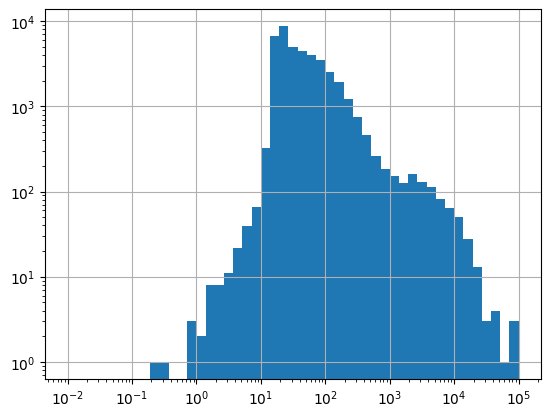

In [99]:
# What do the least differences look like? Looks like 10-1000m is pretty typical for this subset!
of_interest.groupby("my_id")["geometry_dist_m"].min().hist(
    log=True, bins=np.logspace(-2, 5, num=50, base=10)
)
plt.xscale("log")